In [57]:
from sampler import RandomFieldSPDE
from fenics import *
from ufl import tanh
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

mesh = Mesh()
with XDMFFile("flower.xdmf") as f:
    f.read(mesh)
d = mesh.topology().dim()
bfun = MeshFunction("size_t",mesh,d-1,0)
INNER,OUTER = 100,200
AutoSubDomain(lambda x,bc: bc).mark(bfun,OUTER)
AutoSubDomain(lambda x,bc: x[0]**2+x[1]**2 <= 0.6**2 and bc).mark(bfun,INNER)

fe = FiniteElement("P",mesh.ufl_cell(),1)
V = FunctionSpace(mesh,fe)

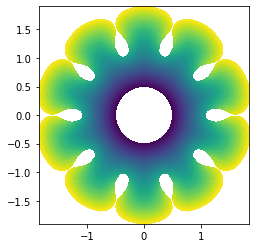

In [58]:
u,v = TrialFunction(V),TestFunction(V)

# Interpolation between outer and inner layer
dist = Function(V,name="distance")
bcs = [DirichletBC(V,0.0,bfun,INNER),DirichletBC(V,1.0,bfun,OUTER)]
solve(inner(grad(u),grad(v))*dx==Constant(0.0)*v*dx(mesh),dist,bcs)

dist2 = Function(V,name="distance2")
normalized = lambda g: g/sqrt(dot(g,g))
solve(inner(grad(u),grad(v))*dx==inner(normalized(grad(dist)),grad(v))*dx,
      dist2,DirichletBC(V,0.0,bfun,INNER))

plot(dist2)

sf = Constant(10.0,name="sf")
st = Constant(1.0,name="st")

t = normalized(grad(dist2))
fib = as_vector([t[1],-t[0]])

ff = outer(fib,fib)
R0 = Constant(0.5)
ee = Constant(0.05)
sfhump = st + (sf-st)/2.0*(1-tanh((dist2-R0)/ee))
sthump = st/sfhump
D = sfhump*ff + sthump*(Identity(d) - ff)

In [65]:
sampler = RandomFieldSPDE(V,N=20,rho=0.05,D=D)

In [66]:
s = next(sampler.sample(1))

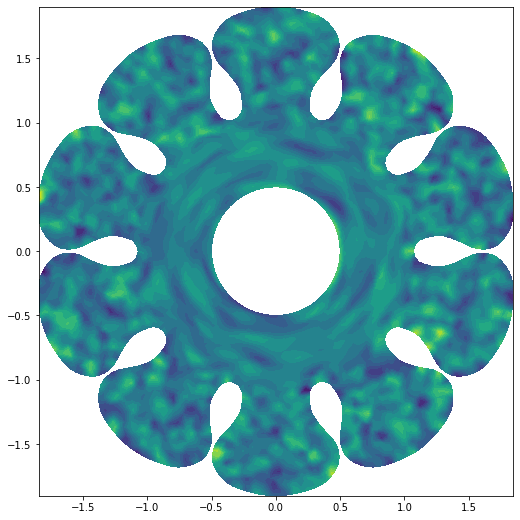

In [67]:
fig = plt.figure(figsize=(9,9))
plot(s,levels=20)